In [1]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import folium
import json
#from ipywidgets import IntSlider, interact
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.decomposition import PCA
from scipy import stats
from sklearn import preprocessing
import math

## Yield Dataset

In [2]:
#reading the FAO data set
fertilizer_area=pd.read_csv('./data/Environment_Fertilizers_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')
crops=pd.read_csv('./data/Production_Crops_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')

In [3]:
crop_corr=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
        .query('`Year Code` == 2004')
        .query('`Item Code` >1000')
        .pivot(index='Area',columns='Item',values='Value')
        .reset_index()
          )
print(crop_corr.shape[0])
crop_corr.head()

244


Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,Afghanistan,12770.0,13348.0,78025.0,12106.0,3624.0,79157.0,3981.0,2725.0,10769.0,176471.0,12909.0,132255.0
1,Africa,13324.0,13988.0,90024.0,11963.0,3563.0,74572.0,3113.0,2716.0,5676.0,87147.0,6764.0,92421.0
2,Albania,34663.0,34663.0,74994.0,39264.0,2972.0,150953.0,3969.0,3713.0,10197.0,149346.0,46290.0,189790.0
3,Algeria,13440.0,13441.0,138702.0,13155.0,1426.0,50839.0,9834.0,4699.0,8049.0,203585.0,12473.0,131958.0
4,American Samoa,NaN,NaN,NaN,NaN,NaN,36975.0,1709.0,2777.0,NaN,35805.0,NaN,42432.0


In [4]:
area_indexed=crops.query('`Element Code` == 5419 and `Item Code` >1000 and `Area Code`<300').set_index(['Area Code', 'Item'])
area_indexed.head()

Area  Item Code  Element Code  \
Area Code Item                                                              
2         Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   

                                    Element  Year Code  Year   Unit    Value  \
Area Code Item                                                                 
2         Cereals (Rice Milled Eqv)   Yield       1961  1961  hg/ha  10831.0   
          Cereals (Rice Milled Eqv)   Yield       1962  1962  hg/ha  10480.0   
          Cereals (Rice Milled Eqv)   Yield       1963  1963  hg/ha   9548.0   
          Cereals (Rice Milled Eqv)   Yield       1964  1964  hg/ha  10461.0   
          Cereals (Rice Milled Eqv)   Yield       1965  1965  hg/ha  10621.0   

                                    Flag  
Area Code Item                            
2         Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc

In [5]:
ferti_range=pd.Series(range(2002,2016+1,1))
missing_values=pd.DataFrame(columns=['Area Code','Item','Year'])
for area in area_indexed.index.get_level_values(level=0).unique().values:
    for item in area_indexed.loc[area].index.unique().values:
        year_missing=ferti_range[~ferti_range.isin(area_indexed.loc[area].loc[item].query('Year>=2002 and Year <=2016').Year)]
        for year in year_missing:
            missing_values =missing_values.append({'Area Code':area,'Item':item,'Year':year},ignore_index=True)
missing_values.head()

,Area Code,Item,Year
0,2,Fibre Crops Primary,2015
1,2,Fibre Crops Primary,2016
2,2,"Oilcrops, Cake Equivalent",2015
3,2,"Oilcrops, Cake Equivalent",2016
4,2,"Oilcrops, Oil Equivalent",2015


In [6]:
#NCreating the 2nd dataset
dropnan_crops=crops.dropna(axis=0, subset=['Value']).query('Year >= 2002 and `Element Code`==5419 and `Item Code` >1000')

In [7]:

count=0
#Purpose of this code : adding missing value by interpolation 
for x in missing_values['Area Code'].unique():
    for j in missing_values.query('`Area Code` == @x').Item.unique():
        if dropnan_crops.query('`Area Code` == @x').query('`Item` == @j').shape[0]>=5 : # That condition is set to avoid replacing value for countries with not enough values
            interpolation_coef = np.polyfit(dropnan_crops.query('`Area Code` == @x').query('Item == @j').Year,
                                            dropnan_crops.query('`Area Code` == @x').query('Item == @j').Value,
                                            1)
            poly = np.poly1d(interpolation_coef)
            for year in missing_values.query('`Area Code` == @x').query('`Item` == @j').Year.values:
                interp_value = poly(year)
                template = (dropnan_crops.query('`Area Code` == @x')
                                        .query('`Item` == @j').head(1))
                to_add = template.values
                to_add[0][9] = interp_value
                to_add[0][6] = year
                to_add[0][7] = year
                to_add=pd.DataFrame(to_add, columns=template.columns.values)
                crops=crops.append(to_add, ignore_index=True, sort=False)
                count+=1
                #t=t.append(to_add,ignore_index=True)
print("The operation replaced %d values"%count)

The operation replaced 1371 values


In [8]:
# To avoid duplicated index or other index issues
crops=crops.reset_index()
crops.drop(columns=['index'],axis=1, inplace=True)
crops.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0,F


In [10]:
crops.to_pickle("crops_interpolated")

In [11]:
crops=pd.read_pickle("crops_interpolated")

## Emissions Dataset

In [12]:
#Load the data set
total_emissions = pd.read_csv('./data/Emissions_AllAgriculture.csv', sep=',', encoding = 'latin-1')
total_emissions.columns = ('domain_code', 'domain', 'area_code','area', 'element_code','element','item_code', 'item','year_code','year','unit','value','flag', 'flag_description','note')
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1962,1962,gigagrams,5151.5228,A,"Aggregate, may include official, semi-official...",NaN


In [13]:
#load the area dataset to use for normalization
total_area=pd.read_csv('./data/LandUse.csv',sep=',',encoding='latin-1')
total_area_agriculture = total_area.query("Item == 'Agriculture'")
total_area_agriculture.head(2)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
114,RL,Land Use,2,Afghanistan,5110,Area,6602,Agriculture,1961,1961,1000 ha,37700.0,Fc,Calculated data
115,RL,Land Use,2,Afghanistan,5110,Area,6602,Agriculture,1962,1962,1000 ha,37760.0,Fc,Calculated data


In [14]:
total_emissions = pd.merge(total_emissions, total_area_agriculture.loc[:,['Value', 'Area','Year']], left_on = ['area','year'], right_on = ['Area','Year'])
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5059,Manure Management,1961,1961,gigagrams,367.8310,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961


In [15]:
total_emissions['emissions_ha'] = total_emissions.value / total_emissions.Value
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year,emissions_ha
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961,0.134068
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5059,Manure Management,1961,1961,gigagrams,367.8310,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961,0.009757


In [16]:
total_emissions[total_emissions.emissions_ha.isnull()]

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year,emissions_ha


In [17]:
missing_total = total_emissions[total_emissions.emissions_ha ==0].shape
total = total_emissions.shape
percent = (missing_total[0] / total[0])*100

print('There are %d values with %d equal to 0 which is %d percent'%(total[0], missing_total[0], percent))

There are 92067 values with 3157 equal to 0 which is 3 percent


In [18]:
total_emissions.query('emissions_ha == 0').head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year,emissions_ha
271,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5061,Synthetic Fertilizers,1994,1994,gigagrams,0.0,EA,NaN,NaN,37813.0,Afghanistan,1994,0.0
280,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5061,Synthetic Fertilizers,1995,1995,gigagrams,0.0,EA,NaN,NaN,37753.0,Afghanistan,1995,0.0


In [19]:
total_emissions = total_emissions[(total_emissions['emissions_ha'] != 0)]

In [20]:
missing_total_2 = total_emissions[total_emissions.emissions_ha ==0].shape
print('There are %d values equal to 0'%(missing_total_2[0]))

There are 0 values equal to 0


## Important Functions

In [63]:
emissions_fertilizer = total_emissions.query("item == 'Synthetic Fertilizers'")
#plt.hist(emissions_fertilizer.emissions_ha, log = True)
np.percentile(emissions_fertilizer.emissions_ha, 99.7)
#np.percentile(emissions_fertilizer.emissions_ha, 66.0)

9.699219770000205

In [74]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth

# #############################################################################
# Generate sample data
X = np.array(emissions_fertilizer.emissions_ha)
X = np.reshape(X, (-1, 1))

# #############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
# bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=100)

ms = MeanShift(bandwidth=None, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)
print(labels)

number of estimated clusters : 30
[0 0 0 ... 0 0 0]


In [64]:
y = min(emissions_fertilizer.emissions_ha)
x = max(emissions_fertilizer.emissions_ha)

print(x,y)

240.34891891891894 9.624639076034648e-08


In [67]:
# This function separate countries in three different groups according to their fertilizer emissions
def emissions_class(x, L): 
    ''' x is the emissions value, L is the set of emissions values'''
    if x<np.percentile(L,33):
        return 'low'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'medium'
    else:
        return 'high'

In [71]:
def umap_year(year, n_components=2): 
    yield_for_merge=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .query('`Area Code` <300') # Exclusion of grouped areas
            .pivot(index='Area',columns='Item',values='Value')
            .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])# drop columns with to many missing values
            .reset_index()
            
              )
    yield_for_merge['Cereal']=yield_for_merge.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    yield_for_merge.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    yield_for_merge=yield_for_merge.dropna(axis=0)
    yield_for_umap=yield_for_merge.drop('Area',axis=1).values 
    
    #Normalization 
    x = yield_for_umap
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    yield_for_umap = pd.DataFrame(x_scaled)
    
    reducer = umap.UMAP(random_state=1, n_components= n_components)
    embedding = reducer.fit_transform(yield_for_umap)
    embedding2=pd.DataFrame(embedding)
    embedding2=pd.merge(embedding2,yield_for_merge['Area'], left_index=True, right_index=True)
    
    #importation of emissions
    umap_emissions=(total_emissions
                    .query('Year == @year')
                    .query("item == 'Synthetic Fertilizers'")
                    )
    embedding2=pd.merge(embedding2,umap_emissions.loc[:,['Area','emissions_ha']],left_on='Area',right_on='Area')
    
    #Result normalization to be able to compare them between years
    embedding2[0]=(embedding2[0]-min(embedding2[0]))/(max(embedding2[0])-min(embedding2[0]))
    embedding2.rename(columns={0: "Umap"}, inplace=True)
    embedding2['emissions_ha']=(embedding2['emissions_ha']-min(embedding2['emissions_ha']))/(max(embedding2['emissions_ha'])-min(embedding2['emissions_ha']))
    embedding2['emissions_class']=embedding2.emissions_ha.apply(lambda x: emissions_class(x, embedding2.emissions_ha))
    
    coef = np.polyfit(embedding2['Umap'],embedding2.emissions_ha,1)
    
    return year,embedding2,coef # return year (for confirmation), performed umap and value of linear regression

## UMAP

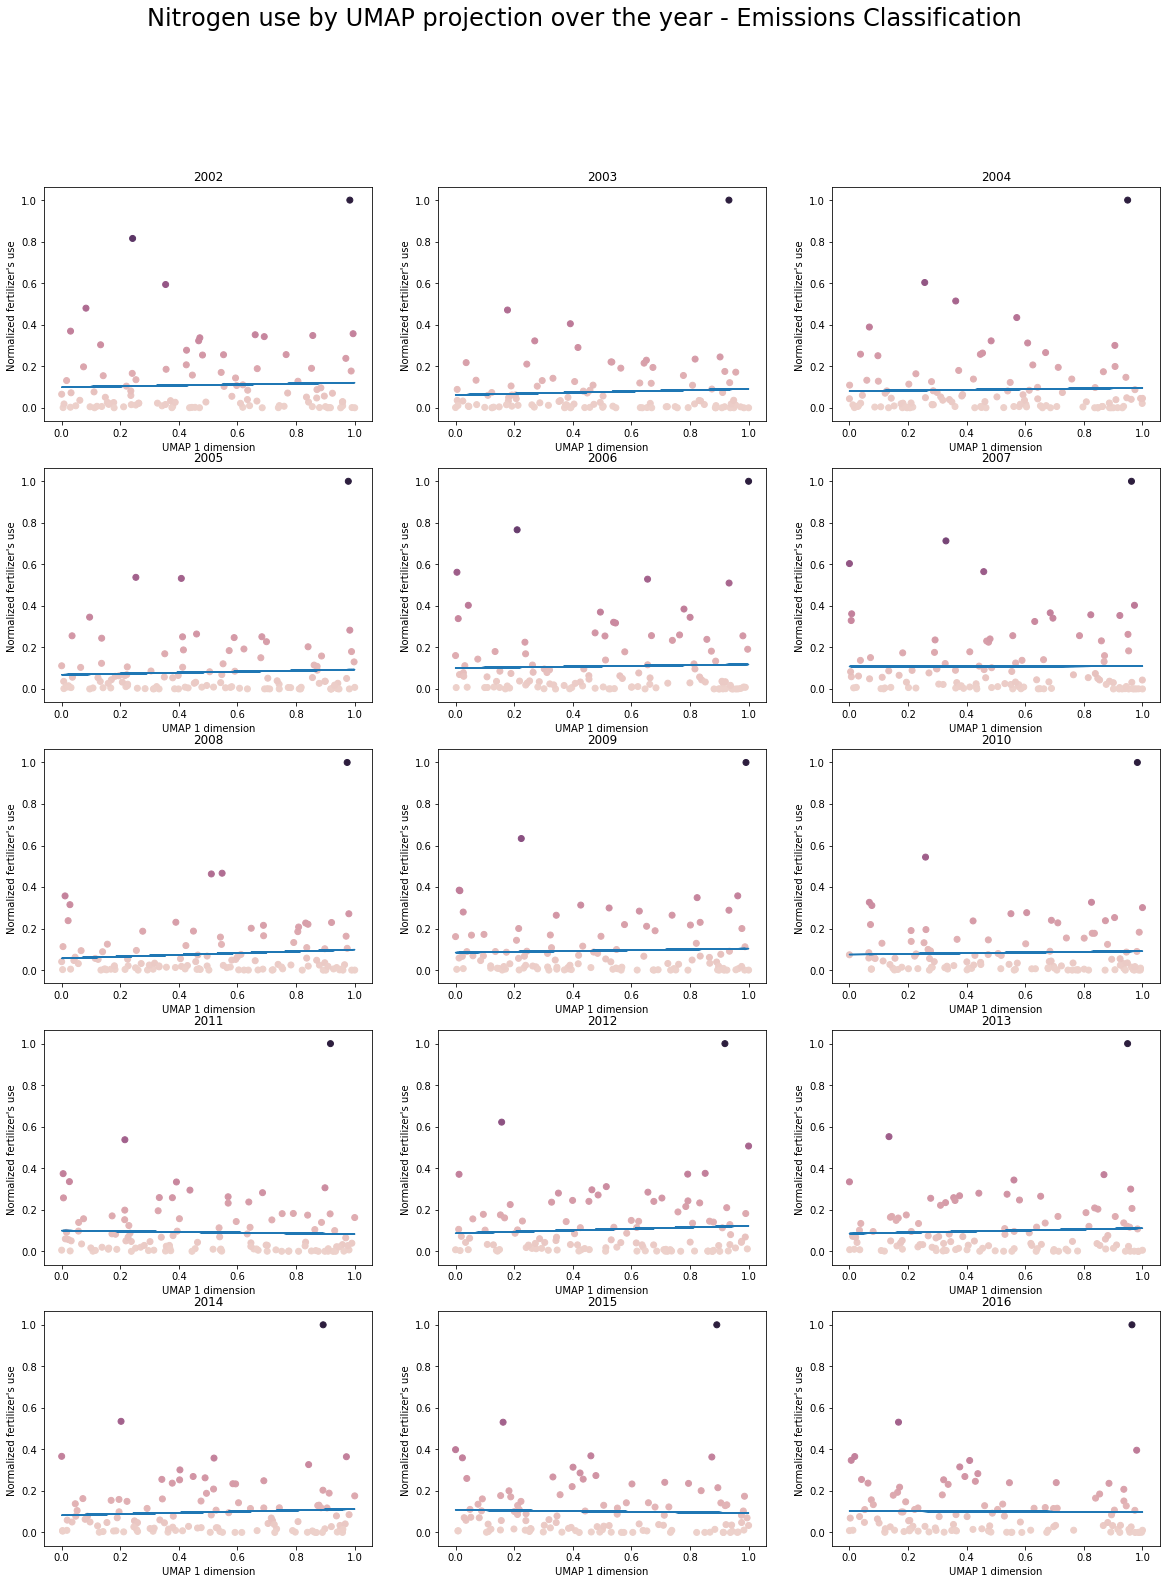

In [72]:
#plot for multiple years for Nutrient nitrogen N vs umap
year=range(2002,2017)
n=len(year)
fig = plt.figure(figsize = (20, math.ceil(n/3)*5 ))
fig.suptitle('Nitrogen use by UMAP projection over the year - Emissions Classification', fontsize=24)
for x in range (n) : 
    vis_2016=umap_year(year[x], 1)
    ax1 = fig.add_subplot(math.ceil(n/3),3,x+1)
    embedding2=vis_2016[1] 
    coef = vis_2016[2]
    poly1d_fn = np.poly1d(coef)
    clarity_ranking = embedding2.emissions_ha
    cmap = sns.cubehelix_palette(as_cmap=True)
    plt.scatter(embedding2['Umap'], embedding2.emissions_ha,c=clarity_ranking, cmap=cmap)
    plt.plot(embedding2['Umap'], poly1d_fn(embedding2['Umap']))
    plt.title('%d'%year[x]);
    plt.xlabel("UMAP 1 dimension")
    plt.ylabel("Normalized fertilizer's use ")

Text(0, 0.5, 'Interpolation Coef')

<Figure size 1440x1080 with 0 Axes>

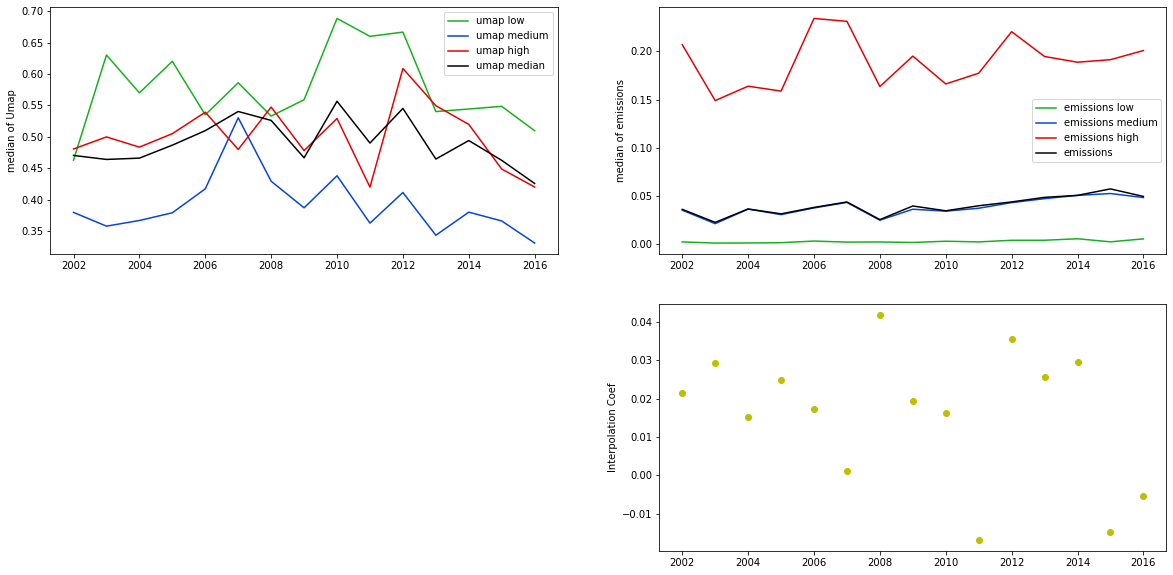

In [73]:
fig = plt.figure(figsize = (20, 15))
fig.suptitle('Evolution of the interpolation coefficient of each fertilizer over the year ', fontsize=25)

umap_plot=[]
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    umap_result=umap_year(year,1)
    low_median=umap_result[1].emissions_ha[umap_result[1].emissions_class=='low'].median()
    medium_median=umap_result[1].emissions_ha[umap_result[1].emissions_class=='medium'].median()
    high_median=umap_result[1].emissions_ha[umap_result[1].emissions_class=='high'].median()
    emissions_median=umap_result[1].emissions_ha.median()
    
    umap_low_median=umap_result[1].Umap[umap_result[1].emissions_class=='low'].median()
    umap_medium_median=umap_result[1].Umap[umap_result[1].emissions_class=='medium'].median()
    umap_high_median=umap_result[1].Umap[umap_result[1].emissions_class=='high'].median()
    umap_median=umap_result[1].Umap.median()
    
    umap_plot.append([umap_result[0],umap_result[2][0],low_median,medium_median,high_median,emissions_median,
                         umap_low_median,umap_medium_median,umap_high_median,umap_median])
    
umap_plot=pd.DataFrame(umap_plot, 
                          columns= ['Year','Coef','emissions low','emissions medium','emissions high','emissions',
                                          'umap low','umap medium','umap high','umap median'])

colors = ["green", "blue", "red"]

figure = plt.figure(figsize = (20,10))
ax1 = figure.add_subplot(2,2,1)
ax1.plot("Year", "umap low", data=umap_plot, color=sns.xkcd_palette(colors)[0])
ax1.plot("Year", "umap medium", data=umap_plot, color=sns.xkcd_palette(colors)[1])
ax1.plot("Year", "umap high", data=umap_plot, color=sns.xkcd_palette(colors)[2])
ax1.plot("Year", "umap median", data=umap_plot, color=sns.xkcd_rgb["black"])
ax1.set_ylabel('median of Umap')
ax1.legend()

ax2 = figure.add_subplot(2,2,2)
ax2.plot("Year", "emissions low", data=umap_plot, color=sns.xkcd_palette(colors)[0])
ax2.plot("Year", "emissions medium", data=umap_plot, color=sns.xkcd_palette(colors)[1])
ax2.plot("Year", "emissions high", data=umap_plot, color=sns.xkcd_palette(colors)[2])
ax2.plot("Year", "emissions", data=umap_plot, color=sns.xkcd_rgb["black"])
ax2.set_ylabel('median of emissions')
ax2.legend()

ax4 = figure.add_subplot(2,2,4)
ax4.plot("Year", 'Coef', 'yo', data=umap_plot)
ax4.set_ylabel('Interpolation Coef')

## PCA

In [142]:
def pre_processing_PCA(df, target, features):
    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the countries
    y = df.loc[:,[target]].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    return x

def PCA_processing(df, target, features):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(pre_processing_PCA(df, target, features))
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
    return pca,pd.concat([principalDf, df[[target]]], axis=1)

In [161]:
years = []
PC1_low = []
PC1_medium = []
PC1_high = []
PC1 = []
emissions_low = []
emissions_medium = []
emissions_high = []
emissions = []
emissions_effect = []
proportion_explained = []


for year in range(2002,2016):
    years += [year]
    
    grouped_yield=crops.query('`Element Code` == 5419')\
        .query('`Year Code` == @year')\
        .query('`Item Code` >1000')\
        .query('`Area Code` <300')\
        .pivot(index='Area',columns='Item',values='Value')\
        .dropna(axis=0)\
        .reset_index()


    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])


    emissions_pca=(total_emissions
                    .query('Year == @year')
                    .query("item == 'Synthetic Fertilizers'")
                    )

    grouped_yield_pca=pd.merge(grouped_yield_pca,emissions_pca.loc[:,['Area','emissions_ha']],left_on='Area',right_on='Area')
    grouped_yield_pca['emissions_class']=grouped_yield_pca.emissions_ha.apply(lambda x: emissions_class(x, grouped_yield_pca.emissions_ha))

    PC1_low += [np.median(grouped_yield_pca.PC1[grouped_yield_pca.emissions_class=='low'])]
    PC1_medium += [np.median(grouped_yield_pca.PC1[grouped_yield_pca.emissions_class=='medium'])]
    PC1_high += [np.median(grouped_yield_pca.PC1[grouped_yield_pca.emissions_class=='high'])]
    PC1 += [np.median(grouped_yield_pca.PC1)]
    
    
    #print(len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='low']),len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='medium']),len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='high']))
    emissions_low += [np.median(grouped_yield_pca.emissions_ha[grouped_yield_pca.emissions_class=='low'])]
    emissions_medium += [np.median(grouped_yield_pca.emissions_ha[grouped_yield_pca.emissions_class=='medium'])]
    emissions_high += [np.median(grouped_yield_pca.emissions_ha[grouped_yield_pca.emissions_class=='high'])]
    
    emissions += [np.median(grouped_yield_pca.emissions_ha)]
    
    grouped_yield_pca.dropna(axis=0, inplace=True)
    grouped_yield_pca.PC1=(grouped_yield_pca.PC1-min(grouped_yield_pca.PC1))/(max(grouped_yield_pca.PC1)-min(grouped_yield_pca.PC1))
    grouped_yield_pca.emissions_ha=(grouped_yield_pca.emissions_ha-min(grouped_yield_pca.emissions_ha))/(max(grouped_yield_pca.emissions_ha)-min(grouped_yield_pca.emissions_ha))
    
    emissions_effect += [np.poly1d(np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.emissions_ha,1))[1]]
    proportion_explained += [pca.explained_variance_ratio_[0]]

Text(0, 0.5, 'emissions effect')

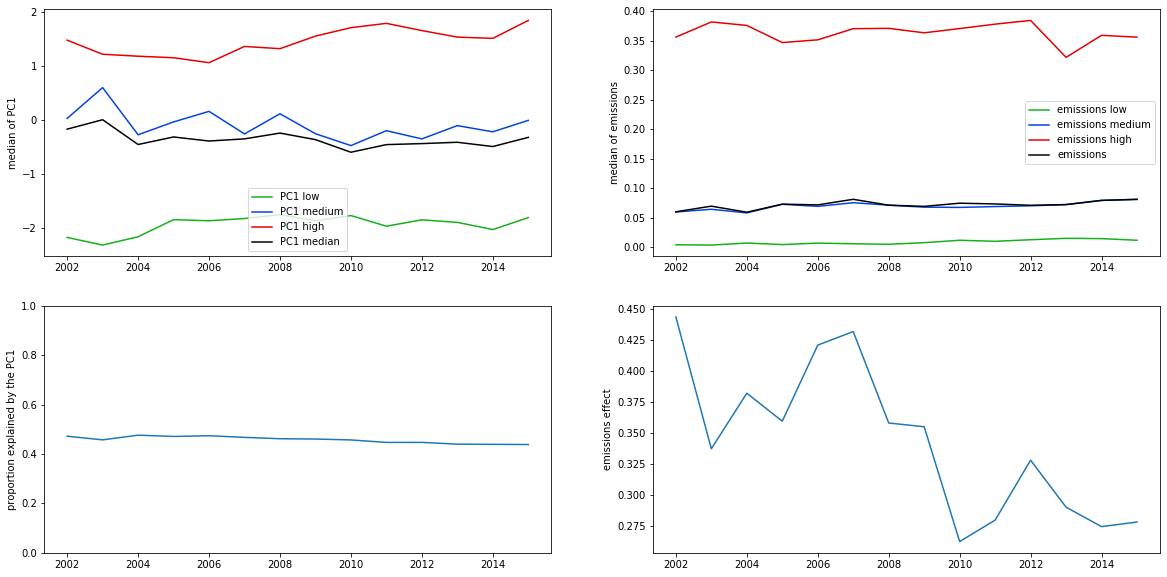

In [163]:
evolution_emissions = pd.DataFrame([years, PC1_low, PC1_medium, PC1_high, emissions_low, emissions_medium, emissions_high,emissions,PC1, proportion_explained, emissions_effect], ['year', 'PC1 low', 'PC1 medium', 'PC1 high','emissions low', 'emissions medium', 'emissions high','emissions','PC1 median', 'proportion explained', 'emissions_effect']).T
colors = ["green", "blue", "red"]

figure = plt.figure(figsize = (20,10))
ax1 = figure.add_subplot(2,2,1)
ax1.plot("year", "PC1 low", data=evolution_emissions, color=sns.xkcd_palette(colors)[0])
ax1.plot("year", "PC1 medium", data=evolution_emissions, color=sns.xkcd_palette(colors)[1])
ax1.plot("year", "PC1 high", data=evolution_emissions, color=sns.xkcd_palette(colors)[2])
ax1.plot("year", "PC1 median", data=evolution_emissions, color=sns.xkcd_rgb["black"])
ax1.set_ylabel('median of PC1')
ax1.legend()

ax2 = figure.add_subplot(2,2,2)
ax2.plot("year", "emissions low", data=evolution_emissions, color=sns.xkcd_palette(colors)[0])
ax2.plot("year", "emissions medium", data=evolution_emissions, color=sns.xkcd_palette(colors)[1])
ax2.plot("year", "emissions high", data=evolution_emissions, color=sns.xkcd_palette(colors)[2])
ax2.plot("year", "emissions", data=evolution_emissions, color=sns.xkcd_rgb["black"])
ax2.set_ylabel('median of emissions')
ax2.legend()

ax3 = figure.add_subplot(2,2,3)
ax3.plot("year", 'proportion explained', data=evolution_emissions)
ax3.set_ylabel('proportion explained by the PC1')
ax3.set_ylim([0,1])

ax4 = figure.add_subplot(2,2,4)
ax4.plot("year", 'emissions_effect', data=evolution_emissions)
ax4.set_ylabel('emissions effect')